## 1. Importing Libraries and datasets

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

In [74]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

## 2. Data Understanding

In [75]:
train_ds, valid_ds = ds["train"], ds["validation"]

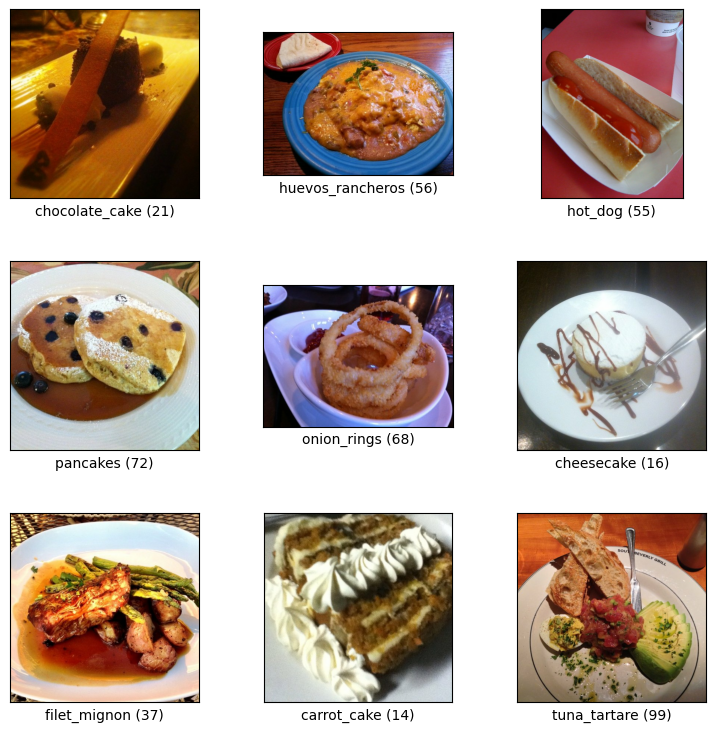

In [76]:
fig = tfds.show_examples(train_ds, ds_info)

## 3. Data Preprocessing

In [77]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

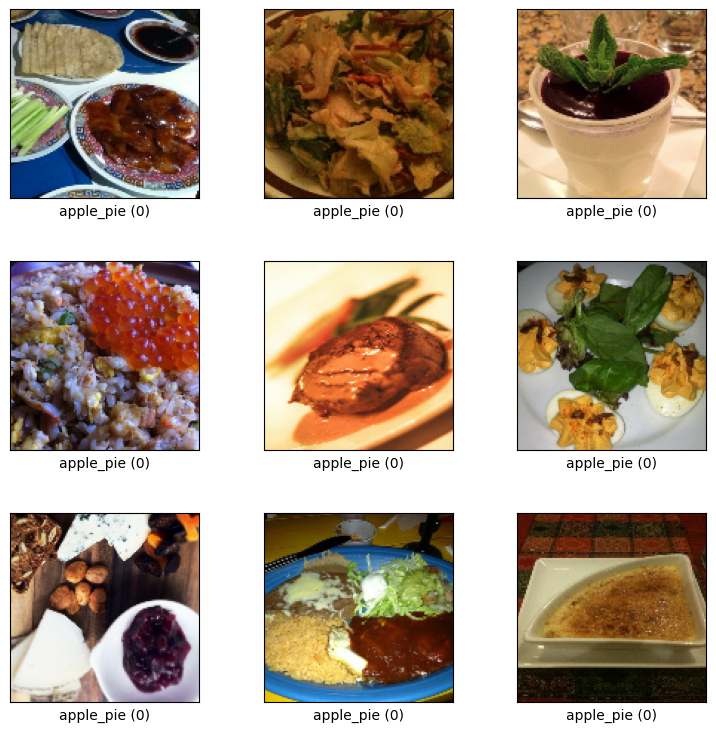

In [78]:
fig = tfds.show_examples(train_ds, ds_info)

In [79]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image, label: label == 0)


In [80]:
valid_hotdogs = valid_ds.filter(lambda image, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda image, label: label == 0)

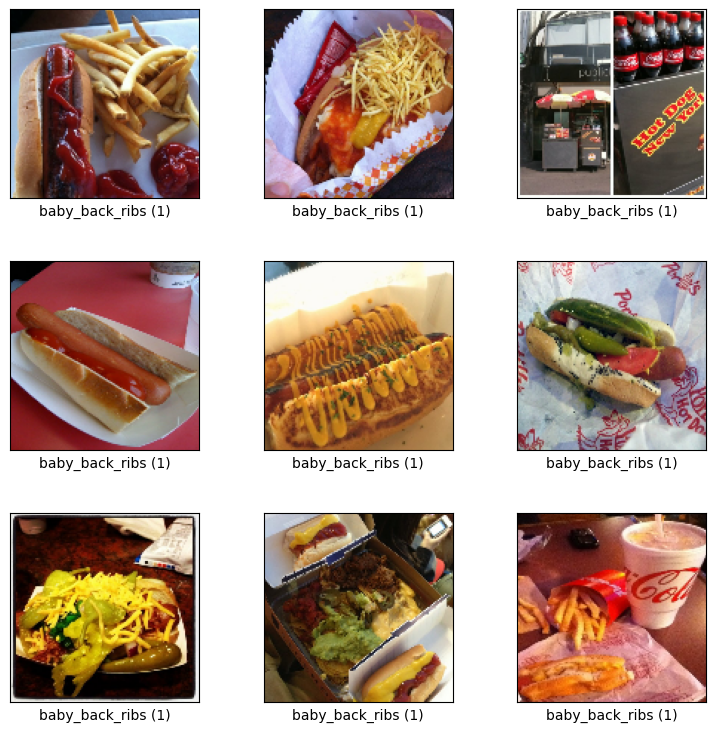

In [81]:
fig = tfds.show_examples(train_hotdogs, ds_info)

In [82]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


## 4. Modeling

In [96]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [84]:
for i,_ in ds["train"].take(1):
  image = i

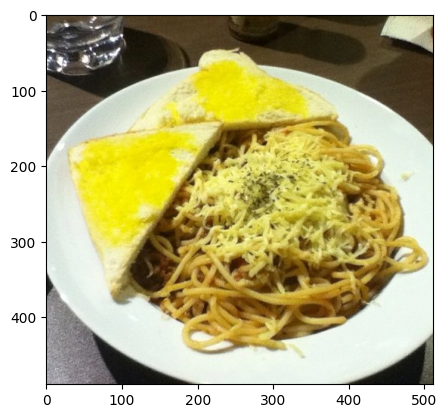

In [85]:
plt.imshow(image)

In [86]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

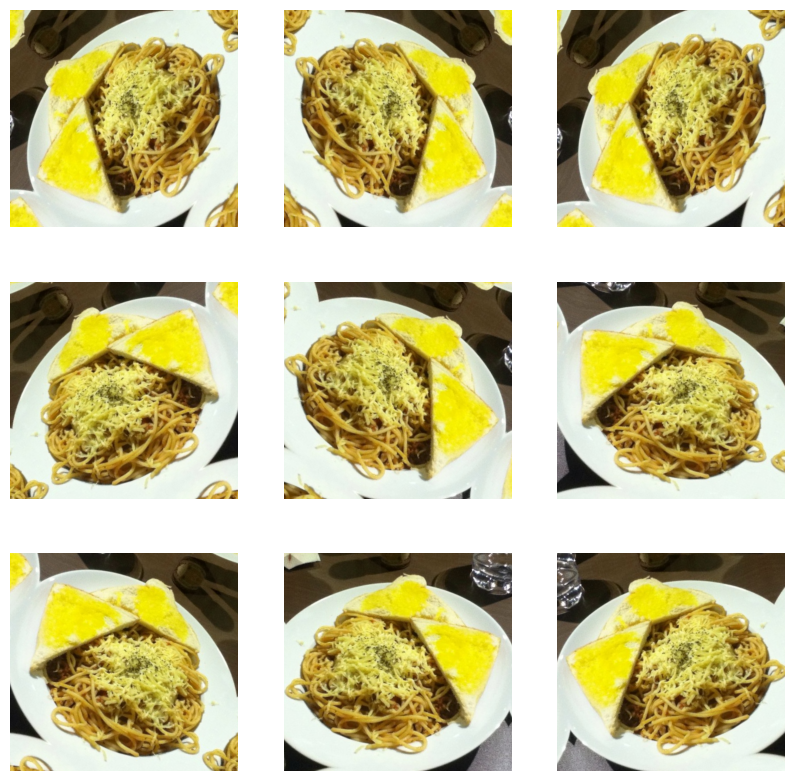

In [87]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [100]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=[MAX_SIDE_LEN, MAX_SIDE_LEN, 3]))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

In [101]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5109 - loss: 1.5875 - val_accuracy: 0.5000 - val_loss: 1.1848
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5215 - loss: 1.1075 - val_accuracy: 0.5047 - val_loss: 0.9415
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5337 - loss: 0.9118 - val_accuracy: 0.5167 - val_loss: 0.8383
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5471 - loss: 0.8254 - val_accuracy: 0.5900 - val_loss: 0.7814
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5438 - loss: 0.7811 - val_accuracy: 0.5760 - val_loss: 0.7546
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5577 - loss: 0.7547 - val_accuracy: 0.6160 - val_loss: 0.7261
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5658 - loss: 0.7283 - val_accuracy: 0.6073 - val_loss: 0.7105
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5755 - loss: 0.7106 - val_acc

In [103]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

def predict_image(model, img_path, input_size=(128, 128)):
  img = load_img(img_path, target_size=input_size)
  img_array = img_to_array(img)
  img_array = img_array / 255.0
  img_array = np.expand_dims(img_array, axis=0)
  prediction = model.predict(img_array)
  if prediction[0][0] > 0.5:
    return "Hotdog"
  else:
    return "Not Hotdog"


In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
img_path = '/content/drive/MyDrive/2025/datas/eggs.jpg'
result = predict_image(model, img_path, input_size=(MAX_SIDE_LEN, MAX_SIDE_LEN))
print(f"Prediction: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: Not Hotdog


In [ ]:
# this project is a fail for me but i did learn a lot.